# Setup and Imports 

In [1]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import numpy as np
from torchvision.utils import save_image
from torch_fidelity import calculate_metrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 64
workers = 4

dataset = dset.ImageFolder(root="data",
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

# Model Architecture 

In [4]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, color_channels, discriminator_features):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            
            # Input: (input_channels) x 64 x 64
            nn.Conv2d(color_channels, discriminator_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features) x 32 x 32
            
            nn.Conv2d(discriminator_features, discriminator_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 2),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features*2) x 16 x 16
            
            nn.Conv2d(discriminator_features * 2, discriminator_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 4),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features*4) x 8 x 8
            
            nn.Conv2d(discriminator_features * 4, discriminator_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 8),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features*8) x 4 x 4
            
            nn.Conv2d(discriminator_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.dis(input).view(-1)    

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim, generator_features, color_channels):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: (latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, generator_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_features * 8),
            nn.ReLU(),
            # State: (512, 4, 4)

            nn.ConvTranspose2d(generator_features * 8, generator_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features * 4),
            nn.ReLU(),
            # State: (256, 8, 8)

            nn.ConvTranspose2d(generator_features * 4, generator_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features * 2),
            nn.ReLU(),
            # State: (128, 16, 16)

            nn.ConvTranspose2d(generator_features * 2, generator_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features),
            nn.ReLU(),
            # State: (64, 32, 32)

            nn.ConvTranspose2d(generator_features, color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (3, 64, 64)
        )

    def forward(self, x):
        return self.gen(x)

In [6]:
def generate_and_save_fid_samples(generator, num_samples, dir):
    os.makedirs(dir, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for i in range(num_samples // batch_size + 1):
            z = torch.randn(batch_size, 100, 1, 1).to(device)
            fake_images = generator(z)
            for j, img in enumerate(fake_images):
                idx = i * batch_size + j
                if idx >= num_samples:
                    break
                save_image(img, f"{dir}/sample_{idx}.png", normalize=True)
    generator.train()

# Training 

In [7]:
gnet = Generator(latent_dim=100, generator_features=64, color_channels=3).to(device)
dnet = Discriminator(color_channels=3, discriminator_features=64).to(device)

g_optim = torch.optim.Adam(gnet.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(dnet.parameters(), lr=0.0002, betas=(0.5, 0.999))

lossFn = nn.BCELoss()

In [8]:
import os
os.makedirs("samples", exist_ok=True)
os.makedirs("generated_fid_samples", exist_ok=True)

from tqdm.auto import tqdm

epochs = 50

losses = np.zeros((epochs,2))
decisions = np.zeros((epochs,2))

fixed_noise = torch.randn(batch_size, 100, 1, 1).to(device)

for epoch in tqdm(range(epochs)):

    d_loss_epoch = 0
    g_loss_epoch = 0
    d_real_epoch = 0
    d_fake_epoch = 0
    
    for i, (X,_) in enumerate(dataloader):

        real_images = X.to(device)
        batch_size = real_images.size(0)
        fake_images = gnet(torch.randn(batch_size, 100, 1, 1).to(device))

        real = torch.full((batch_size,), 0.9, device=device)
        fake = torch.full((batch_size,), 0.1, device=device)

        # ---- Disctriminator step ----

        # True images
        pred_real = dnet(real_images).view(-1)
        d_loss_real = lossFn(real, pred_real)

        # False images
        pred_fake = dnet(fake_images).view(-1)
        d_loss_fake = lossFn(fake, pred_fake)

        # Combine the losses
        d_loss_combined = d_loss_real + d_loss_fake

        d_optim.zero_grad()
        d_loss_combined.backward()
        d_optim.step()


        # ---- Generator step ----
        fake_images = gnet( torch.randn(batch_size,100,1,1).to(device) )
        pred_fake   = dnet(fake_images)
      
        # compute and collect loss and accuracy
        g_loss = lossFn(pred_fake.squeeze(),real)
         
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()

        d_loss_epoch += d_loss_combined.item()
        g_loss_epoch += g_loss.item()
        d_real_epoch += torch.mean((pred_real>.5).float()).item()
        d_fake_epoch += torch.mean((pred_fake<.5).float()).item()

    losses[epoch, 0] = d_loss_epoch/len(dataloader)
    losses[epoch, 1] = g_loss_epoch/len(dataloader)
    decisions[epoch, 0] = d_real_epoch/len(dataloader)
    decisions[epoch, 1] = d_fake_epoch/len(dataloader)

    if epoch % 1 == 0:
        with torch.no_grad():
            fake = gnet(fixed_noise)
            save_image(fake, f"samples/epoch_{epoch}.png", normalize=True)

    if epoch % 10 == 0:
        generate_and_save_fid_samples(gnet, num_samples=1000, dir="generated_fid_samples")
        
        metrics_dict = calculate_metrics(
            input1="data/data",
            input2="generated_fid_samples",
            cuda=True,
            fid=True,
            isc=False,
            kid=False,
            verbose=False
        )
        
        fid = metrics_dict['frechet_inception_distance']
        print(f"Epoch {epoch}, FID: {fid:.2f}")


C:\Users\litwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]C:\Users\litwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
  2%|█▌                                                                              | 1/50 [04:19<3:31:31, 259.01s/it]

Epoch 0, FID: 347.49


 22%|█████████████████▍                                                             | 11/50 [15:20<1:13:25, 112.96s/it]

Epoch 10, FID: 253.26


 42%|██████████████████████████████████                                               | 21/50 [26:50<57:57, 119.90s/it]

Epoch 20, FID: 167.37


 62%|██████████████████████████████████████████████████▏                              | 31/50 [37:38<34:37, 109.32s/it]

Epoch 30, FID: 147.78


 82%|██████████████████████████████████████████████████████████████████▍              | 41/50 [48:27<16:20, 108.92s/it]

Epoch 40, FID: 173.67


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [55:03<00:00, 66.08s/it]


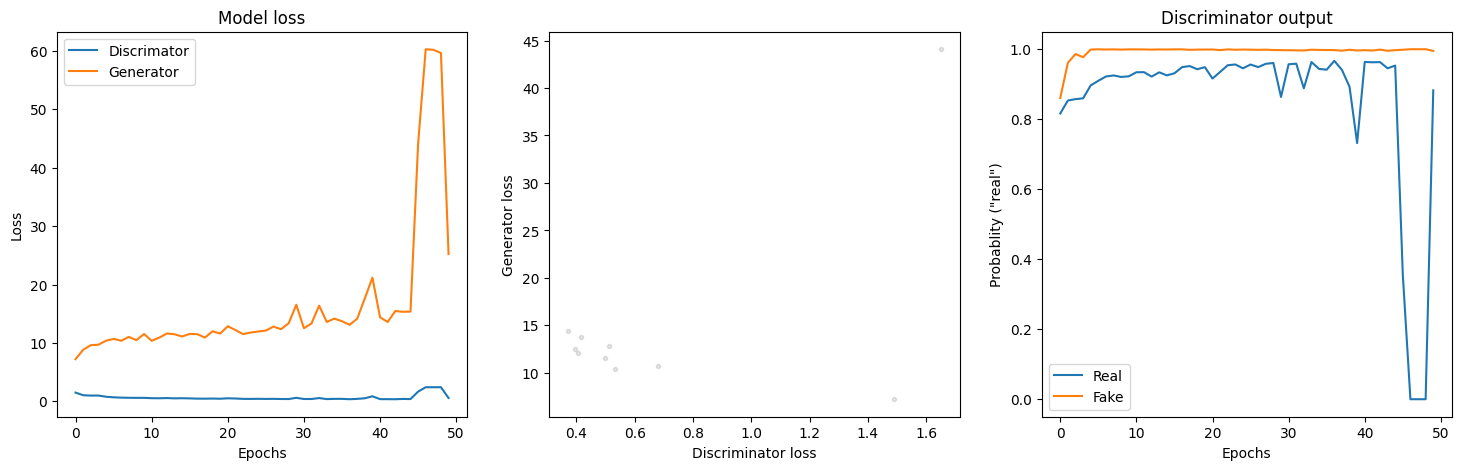

In [9]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(decisions)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

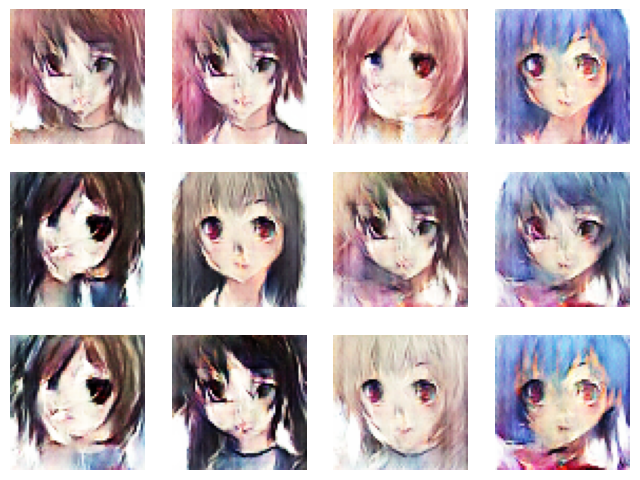

In [10]:
gnet.eval()
with torch.no_grad():
    fake_data = gnet(torch.randn(12, 100, 1, 1).to(device)).cpu()
    
    fake_data = fake_data.permute(0, 2, 3, 1)
    fake_data = (fake_data + 1) / 2 

    fig, axs = plt.subplots(3, 4, figsize=(8, 6))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(fake_data[i])
        ax.axis('off')
    plt.show()

In [11]:

generate_and_save_fid_samples(gnet, num_samples=10000, dir="generated_fid_samples")
        
metrics_dict = calculate_metrics(
    input1="data/data",
    input2="generated_fid_samples",
    cuda=True,
    fid=True,
    isc=False,
    kid=False,
    verbose=False
)
        
fid = metrics_dict['frechet_inception_distance']
print(f"Final FID: {fid:.2f}")

Final FID: 183.44
